# Decision Tree

### General algorithm

In [1]:
import networkx as nx 
import random
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Common neighbours
def CN(x,y,graph):
    s = 0
    for i in graph.neighbors(x):
        for j in graph.neighbors(y):
            if i == j:
                s += 1
    return s

In [3]:
# source : https://stackoverflow.com/questions/15590812/networkx-convert-multigraph-into-simple-graph-with-weighted-edges
def multi_to_weighted(graph): 
    
    # we create the graph with all the nodes from the original dataset
    G = nx.Graph()
    G.add_nodes_from(graph.nodes())
    
    for u,v,data in graph.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
        
    return G

In [4]:
def features_directed(graph, actual_edges, multi = False):
      
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    in_deg = list(graph.in_degree)
    out_deg = list(graph.out_degree)
    # Clustering function does not work for multigraphs
    if multi == True: 
        G = multi_to_weighted(graph)
        CC = nx.clustering(G)
    else:CC = nx.clustering(graph)
    
    data0_X_train = []
    data0_Y_train = []
    data0_nodes_train = []
    X_train, Y_train = [],[]
    X_test, Y_test, nodes_test = [],[],[]
    
    for i in range(n):
        neighbors = [n for n in graph.neighbors(nodes[i])] # list of the neighbors of node i
        for j in range(n):
            if i != j :
                
                if nodes[j] in neighbors: 
                    features = []
                    # there is a link between the nodes in the graph
                    # the training set is composed of all the present edges of the graph
                    
                    Y_train.append(1)
                    features.append(in_deg[i][1])
                    features.append(in_deg[j][1])
                    features.append(out_deg[i][1])
                    features.append(out_deg[j][1])
                    features.append(CC[nodes[i]])
                    features.append(CC[nodes[j]])
                    features.append(CN(nodes[i],nodes[j],graph))
                    X_train.append(features)
                
                if (multi==False and nodes[j] not in neighbors) or (multi==True): 
                    features = []
                    # there is no link between the nodes in the graph, if it is not a multigraph
                    # for multigraphs, we can predict edges already existing in the graph
                    
                    if [nodes[i],nodes[j]] not in actual_edges: 
                        # this is not one of the removed edges
                        data0_nodes_train.append([nodes[i],nodes[j]])
                        data0_Y_train.append(0)
                        features.append(in_deg[i][1])
                        features.append(in_deg[j][1])
                        features.append(out_deg[i][1])
                        features.append(out_deg[j][1])
                        features.append(CC[nodes[i]])
                        features.append(CC[nodes[j]])
                        features.append(CN(nodes[i],nodes[j],graph))
                        data0_X_train.append(features)
                    else: # the testing set is composed of all the present edges previously removed
                        nodes_test.append([nodes[i],nodes[j]])
                        Y_test.append(1)
                        features.append(in_deg[i][1])
                        features.append(in_deg[j][1])
                        features.append(out_deg[i][1])
                        features.append(out_deg[j][1])
                        features.append(CC[nodes[i]])
                        features.append(CC[nodes[j]])
                        features.append(CN(nodes[i],nodes[j],graph))
                        X_test.append(features)

    l = int(len(data0_Y_train)/5) # the number of absent edges in the graph to remove
   
    # We shuffle the data of absence of edges in the same way 
    data0 = list(zip(data0_nodes_train, data0_Y_train, data0_X_train))
    random.shuffle(data0)
    data0_nodes_train, data0_Y_train, data0_X_train = zip(*data0)
    
    # We randomly remove 1/5 of the absent edges of the graph
    X_train += data0_X_train[l:]
    Y_train += data0_Y_train[l:]
    
    # We randomly add the 1/5 to the pairs of nodes to predict
    X_test += data0_X_train[:l]
    Y_test += data0_Y_train[:l]
    nodes_test += data0_nodes_train[:l]
    
    return X_train, Y_train, X_test, Y_test, nodes_test

In [5]:
def features_undirected(graph, actual_edges, multi = False):
      
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    edges = list(graph.edges)
    deg = list(graph.degree)
    # Clustering function does not work for multigraphs
    if multi == True: 
        G = multi_to_weighted(graph)
        CC = nx.clustering(G)
    else:CC = nx.clustering(graph)
    
    data0_X_train = []
    data0_Y_train = []
    data0_nodes_train = []
    X_train, Y_train = [],[]
    X_test, Y_test, nodes_test = [],[],[]
 
    for i in range(n):
        neighbors = [n for n in graph.neighbors(nodes[i])] # list of the neighbors of node i
        for j in range(i+1,n):
            if i != j :
                
                if nodes[j] in neighbors: 
                    features = []
                    # there is a link between the nodes in the graph
                    # the training set is composed of all the present edges of the graph
                    
                    Y_train.append(1)
                    features.append(deg[i][1]+deg[j][1])
                    features.append(max(deg[i][1],deg[j][1])-min(deg[i][1],deg[j][1]))
                    features.append(CC[nodes[i]]+CC[nodes[j]])
                    features.append(max(CC[nodes[i]],CC[nodes[j]])-min(CC[nodes[i]],CC[nodes[j]]))
                    features.append(CN(nodes[i],nodes[j],graph))
                    X_train.append(features)
                
                if (multi==False and nodes[j] not in neighbors) or (multi==True): 
                    features = []
                    # there is no link between the nodes in the graph, if it is not a multigraph
                    # for multigraphs, we can predict edges already existing in the graph
                    
                    # Notation: the nodes of minimum number first                             
                    if [min(nodes[i],nodes[j]),max(nodes[i],nodes[j])] not in actual_edges: 
                        # this is not one of the removed edges
                        data0_nodes_train.append([min(nodes[i],nodes[j]),max(nodes[i],nodes[j])])
                        data0_Y_train.append(0)
                        features.append(deg[i][1]+deg[j][1])
                        features.append(max(deg[i][1],deg[j][1])-min(deg[i][1],deg[j][1]))
                        features.append(CC[nodes[i]]+CC[nodes[j]])
                        features.append(max(CC[nodes[i]],CC[nodes[j]])-min(CC[nodes[i]],CC[nodes[j]]))
                        features.append(CN(nodes[i],nodes[j],graph))
                        data0_X_train.append(features)
                    else: # the testing set is composed of all the present edges previously removed
                        nodes_test.append([min(nodes[i],nodes[j]),max(nodes[i],nodes[j])])
                        Y_test.append(1)
                        features.append(deg[i][1]+deg[j][1])
                        features.append(max(deg[i][1],deg[j][1])-min(deg[i][1],deg[j][1]))
                        features.append(CC[nodes[i]]+CC[nodes[j]])
                        features.append(max(CC[nodes[i]],CC[nodes[j]])-min(CC[nodes[i]],CC[nodes[j]]))
                        features.append(CN(nodes[i],nodes[j],graph))
                        X_test.append(features)         
                

    l = int(len(data0_Y_train)/5) # the number of absent edges in the graph to remove

    # We shuffle the data of absence of edges in the same way 
    data0 = list(zip(data0_nodes_train, data0_Y_train, data0_X_train))
    random.shuffle(data0)
    data0_nodes_train, data0_Y_train, data0_X_train = zip(*data0)
    
    # We randomly remove 1/5 of the absent edges of the graph
    X_train += data0_X_train[l:]
    Y_train += data0_Y_train[l:]
    
    # We randomly add the 1/5 to the pairs of nodes to predict
    X_test += data0_X_train[:l]
    Y_test += data0_Y_train[:l]
    nodes_test += data0_nodes_train[:l]
    
    return X_train, Y_train, X_test, Y_test, nodes_test

Implementation of the decision tree algorithm thanks to https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/.

In [6]:
# Calculate the Gini index for a split dataset

def gini_index(groups, classes): 
    # groups = [Xleft,Yleft],[Xright,Yright]
    
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group[1]))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        
        # score the group based on the score for each class
        for class_val in classes:
            proportion = group[1].count(class_val) / size
            score += proportion * proportion
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
        
    return gini

In [7]:
# Split a dataset based on an attribute and an attribute value

def test_split(index, value, X_train, Y_train):
    
    Xleft, Yleft, Xright, Yright = list(), list(), list(), list()
    for i in range(len(X_train)):
        if X_train[i][index] < value:
            Xleft.append(X_train[i])
            Yleft.append(Y_train[i])
        else:
            Xright.append(X_train[i])
            Yright.append(Y_train[i])
            
    return [Xleft,Yleft],[Xright,Yright]

In [8]:
# Select the best split point for a dataset

def get_split(dataset):
    
    [X_train, Y_train] = dataset
    class_values = list(set(Y_train))
    b_index, b_value, b_score, b_groups = 999999, 999999, 999999, None
    
    for index in range(len(X_train[0])): # for every attribute
        for row in X_train:
            groups = test_split(index, row[index], X_train, Y_train)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
                
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [9]:
# Select the best split point for a dataset

def get_split_random(dataset):
    
    [X_train, Y_train] = dataset
    len_sub = 10
    class_values = list(set(Y_train))
    b_index, b_value, b_score, b_groups = 999999, 999999, 999999, None
    
    for index in range(len(X_train[0])): # for every attribute
        for s in range(len_sub): # for 10 random values
            i = random.randint(0,len(X_train)-1) 
            row = X_train[i]
            groups = test_split(index, row[index], X_train, Y_train)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
                
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [10]:
# Create a terminal node value
# instead of returning a label like a regular decision tree
# we return the value is the score of presence of edge, the propotion of edges in the leaf

def to_terminal(group): 
    # group = [Xgroup,Ygroup]
    score = 0
    [Xgroup, Ygroup] = group
    for y in Ygroup:
        if y == 1:
            score += 1 
    return score/(len(Ygroup))

In [11]:
# Create child splits for a node or make terminal

def split(node, max_depth, min_size, depth):
    # left = [Xleft,Yleft]
    # right = [Xright,Yright]
    
    left, right = node['groups']
    del(node['groups'])
    
    # check for a no split
    if not left[0] or not right[0]:
        node['left'] = node['right'] = to_terminal([left[0] + right[0], left[1] + right[1]])
        return
    
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    
    # process left child
    if len(left[0]) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split_random(left)
        split(node['left'], max_depth, min_size, depth+1)
        
    # process right child
    if len(right[0]) <= min_size:  
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split_random(right)
        split(node['right'], max_depth, min_size, depth+1)

In [12]:
# Build a decision tree

def build_tree(X_train, Y_train, max_depth, min_size):
    
    root = get_split_random([X_train, Y_train])
    split(root, max_depth, min_size, 1)
    return root

In [13]:
def predict(node, row):
    
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict): # not a terminal leaf
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict): # not a terminal leaf
            return predict(node['right'], row)
        else:
            return node['right']

In [14]:
def prediction(graph, actual_edges, max_depth, min_size, network_type='undirected', multi = False):
    
    if network_type == 'directed':
        X_train, Y_train, X_test, Y_test, nodes_test = features_directed(graph, actual_edges, multi)
    else: 
        X_train, Y_train, X_test, Y_test, nodes_test = features_undirected(graph, actual_edges, multi)
        
    tree = build_tree(X_train, Y_train, max_depth, min_size)
    links = []
    scores = []
    
    for i in range(len(X_test)):  
        score = predict(tree,X_test[i])
        links.append(nodes_test[i])
        scores.append(score)
    
    Z = sorted(zip(list(scores),links), reverse=True)
    scores,links = zip(*Z)
    
    return list(scores),list(links)

In [15]:
# function giving all kind of results on performance

def results(scores, predictions, actual_edges, graph):
    
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    n_edges = graph.number_of_edges()
    test_size = len(actual_edges)
    
    precisions = []
    recalls = []
    fp_rates = []
    MAP = 0
    tp = 0
    fp = 0
    tn = len(predictions)-test_size # when 0 positive is predicted
    fn = test_size # when 0 positive is predicted
    stop = False # become true once we reached the threshold limit of 0.5
    
    for k in range(len(predictions)):
        
        if k >= test_size and tp != 0 and stop == False:
            # We compute MAP for the prediction list length of the number of actual edges
            stop = True
            MAP = MAP / tp
            
        if predictions[k] in actual_edges:
            tp += 1
            fn -= 1  
            if k < test_size:
                MAP += (tp /(tp + fp))   
        else:
            fp += 1
            tn -= 1

        if (tp != 0 or fp != 0) and k < test_size:
            # average precision for a prediction list where length=number of actual edges to predict
            # precision = tp /(tp + fp)
            precisions.append(tp/(tp + fp))
            
        if tp != 0 or fn != 0:
        # tp + fn = relevant_edges
            recalls.append(tp/(tp + fn))                 
        if tn != 0 or fp != 0:
            # tn + fp = num_vertices*(num_vertices-1) - num_edges - relevant_edges = irrelevant_edges
            fp_rates.append(fp/(tn + fp))
                
    if tp == 0:  # Not even one good prediction
        return [0]*test_size,0,[0]*(k+1),[0]*(k+1)
    
    return(precisions,MAP,recalls,fp_rates)

In [16]:
# Average results for the 5-CrossValidation

def CV_results(list_graphs, list_targets, max_depth, min_size, network_type='undirected', multi = False):
    test_size = len(list_targets[0])
    precisions, MAP, recalls, fp_rates= [0]*test_size,0,[],[]
    
    for part in range(5):
        
        scores,predictions = prediction(list_graphs[part], list_targets[part], max_depth, min_size, network_type, multi)
      
        if recalls == [] and fp_rates == []:
            recalls, fp_rates = [0]*len(predictions),[0]*len(predictions)
        precisions_N, MAP_N, recalls_N, fp_rates_N = results(scores,predictions,list_targets[part],list_graphs[part])
        precisions,MAP,recalls,fp_rates = [sum(x) for x in zip(precisions,precisions_N)] ,MAP+MAP_N, [sum(x) for x in zip(recalls,recalls_N)], [sum(x) for x in zip(fp_rates,fp_rates_N)]
  
    return([x/5 for x in precisions], MAP/5, [x/5 for x in recalls], [x/5 for x in fp_rates])

In [17]:
def AUROC(fp_rates,recalls):
    score = 0
    
    for x in range(1,len(fp_rates)):
        score += (fp_rates[x]-fp_rates[x-1])*recalls[x]
        
    return score

### First dataset: PROTEINS 

In [18]:
# Importation of the dataset: PROTEINS
# http://konect.uni-koblenz.de/networks/maayan-Stelzl 

PROT = []
with open('out.maayan-Stelzl') as inputfile:
    for line in inputfile:
        PROT.append(line.strip().split(','))
PROT = PROT[1:] # list of all the edges
random.shuffle(PROT) # we randomly shuffle the edges

# test size
num_edges_PROT = len(PROT)
num_vertices_PROT = 1706
test_size_PROT = int(num_edges_PROT/5)

# Contains the 5 parts forming the whole dataset
parts_PROT = []

start = 0
end = test_size_PROT
for part in range(5):  # We create the 5 parts
    if end>num_edges_PROT:
        parts_PROT.append(PROT[start:])
    else:parts_PROT.append(PROT[start:end])
    start = end
    end = start + test_size_PROT

In [19]:
PROT_G = nx.DiGraph()
for edge in range(len(PROT)):
    nodes = PROT[edge][0].split(' ')
    PROT_G.add_edge(int(nodes[0]), int(nodes[1])) 
PROT_nodes = PROT_G.nodes()

In [20]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

PROT_graphs = []
PROT_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.DiGraph()
    G.add_nodes_from(PROT_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_PROT[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                target_links.append([int(nodes[0]),int(nodes[1])])
                
                

    PROT_graphs.append(G)
    PROT_targets.append(target_links)

In [21]:
precisions,MAP,recalls,fp_rates = CV_results(PROT_graphs,PROT_targets,7 ,100 ,'directed')

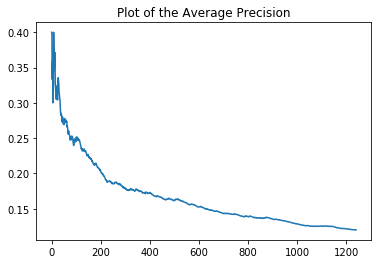

In [22]:
plt.figure()
X = [x for x in range(len(precisions))]
plt.plot(X,precisions)
plt.title('Plot of the Average Precision')
plt.show()

A slow decrease like that characterises a good ranking.

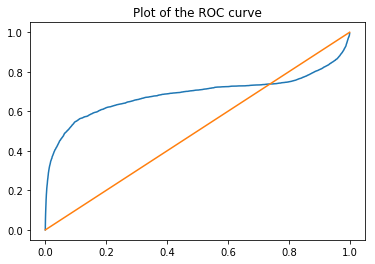

In [23]:
plt.figure()
plt.plot(fp_rates, recalls, fp_rates,fp_rates )
plt.title('Plot of the ROC curve')
plt.show()

In [24]:
AUROC(fp_rates, recalls)

0.6856151056102733

In [25]:
MAP

0.1925870618591326

### Second dataset: INFECTIOUS

In [26]:
# Importation of the dataset: INFECTIOUS
# http://konect.uni-koblenz.de/networks/sociopatterns-infectious 

INF = []
with open('sociopatterns-infectious\out.sociopatterns-infectious') as inputfile:
    for line in inputfile:
        INF.append(line.strip().split(','))
INF = INF[2:] # list of all the edges
random.shuffle(INF) # we randomly shuffle the edges

# test size
num_edges_INF = len(INF)
num_vertices_INF = 410
test_size_INF = int(num_edges_INF/5)

# Contains the 5 parts forming the whole dataset
parts_INF = []

start = 0
end = test_size_INF
for part in range(5):  # We create the 5 parts
    if end>num_edges_INF:
        parts_INF.append(INF[start:])
    else:parts_INF.append(INF[start:end])
    start = end
    end = start + test_size_INF

In [27]:
INF_G = nx.MultiGraph()
for edge in range(len(INF)):
    nodes = INF[edge][0].split(' ')
    INF_G.add_edge(int(nodes[0]), int(nodes[1])) 
INF_nodes = INF_G.nodes()

In [28]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

INF_graphs = []
INF_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.MultiGraph()
    G.add_nodes_from(INF_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_INF[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                # For undirected network, we write the min node first
                # We don't want duplicates because we can predict an edge only once
                # We cannot predict the number of edges to add
                if [min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))] not in target_links:
                    target_links.append([min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))])
                           
    INF_graphs.append(G)
    INF_targets.append(target_links)

In [29]:
precisions_INF, MAP_INF, recalls_INF, fp_rates_INF = CV_results(INF_graphs,INF_targets,5,10,'undirected',True)

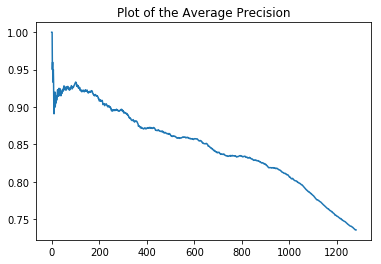

In [30]:
plt.figure()
X_INF = [x for x in range(len(precisions_INF))]
plt.plot(X_INF,precisions_INF)
plt.title('Plot of the Average Precision')
plt.show()

A slow decrease like that characterises a good ranking.

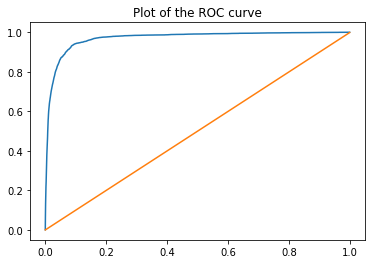

In [31]:
plt.figure()
plt.plot(fp_rates_INF, recalls_INF, fp_rates_INF,fp_rates_INF )
plt.title('Plot of the ROC curve')
plt.show()

In [32]:
AUROC(fp_rates_INF, recalls_INF)

0.9673317356634947

In [33]:
MAP_INF

0.8563457536150552

### Third dataset: ADOLESCENT

In [34]:
# Importation of the dataset: ADOLESCENT
# http://konect.uni-koblenz.de/networks/moreno_health

ADO = []
with open('moreno_health\out.moreno_health_health') as inputfile:
    for line in inputfile:
        ADO.append(line.strip().split(','))
ADO = ADO[2:] # list of all the edges
random.shuffle(ADO) # we randomly shuffle the edges

# test size
num_edges_ADO = len(ADO)
num_vertices_ADO = 2539
test_size_ADO = int(num_edges_ADO/5)

# Contains the 5 parts forming the whole dataset
parts_ADO = []

start = 0
end = test_size_ADO
for part in range(5):  # We create the 5 parts
    if end>num_edges_ADO:
        parts_ADO.append(ADO[start:])
    else:parts_ADO.append(ADO[start:end])
    start = end
    end = start + test_size_ADO

In [35]:
ADO_G = nx.DiGraph()
for edge in range(len(ADO)):
    nodes = ADO[edge][0].split(' ')
    ADO_G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2]))
ADO_nodes = ADO_G.nodes()

In [36]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

ADO_graphs = []
ADO_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.DiGraph()
    G.add_nodes_from(ADO_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_ADO[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                target_links.append([int(nodes[0]),int(nodes[1])])
                
                

    ADO_graphs.append(G)
    ADO_targets.append(target_links)

In [37]:
precisions_ADO,MAP_ADO,recalls_ADO,fp_rates_ADO = CV_results(ADO_graphs,ADO_targets,5,50,'directed')

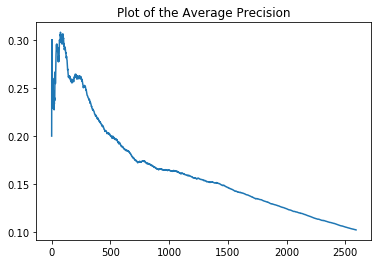

In [38]:
plt.figure()
X_ADO = [x for x in range(len(precisions_ADO))]
plt.plot(X_ADO,precisions_ADO)
plt.title('Plot of the Average Precision')
plt.show()

A slow decrease like that characterises a good ranking.

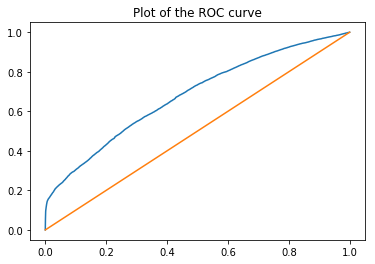

In [39]:
plt.figure()
plt.plot(fp_rates_ADO, recalls_ADO, fp_rates_ADO,fp_rates_ADO )
plt.title('Plot of the ROC curve')
plt.show()

In [40]:
AUROC(fp_rates_ADO, recalls_ADO)

0.6802401459943191

In [41]:
MAP_ADO

0.2005862994388005

### Fourth dataset: MISERABLES

In [42]:
# Importation of the dataset: MISERABLES
# http://konect.uni-koblenz.de/networks/moreno_lesmis

MIS = []
with open('moreno_lesmis\out.moreno_lesmis_lesmis') as inputfile:
    for line in inputfile:
        MIS.append(line.strip().split(','))
MIS = MIS[2:] # list of all the edges
random.shuffle(MIS) # we randomly shuffle the edges

# test size
num_edges_MIS = len(MIS)
num_vertices_MIS = 77
test_size_MIS = int(num_edges_MIS/5)

# Contains the 5 parts forming the whole dataset
parts_MIS = []

start = 0
end = test_size_MIS
for part in range(5):  # We create the 5 parts
    if end>num_edges_MIS:
        parts_MIS.append(MIS[start:])
    else:parts_MIS.append(MIS[start:end])
    start = end
    end = start + test_size_MIS

In [43]:
MIS_G = nx.Graph()
for edge in range(len(MIS)):
    nodes = MIS[edge][0].split(' ')
    MIS_G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2]))
MIS_nodes = MIS_G.nodes()

In [44]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

MIS_graphs = []
MIS_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.Graph()
    G.add_nodes_from(MIS_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_MIS[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                # For undirected network, we write the min node first
                target_links.append([min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))])
                
                

    MIS_graphs.append(G)
    MIS_targets.append(target_links)

In [45]:
precisions_MIS, MAP_MIS, recalls_MIS, fp_rates_MIS = CV_results(MIS_graphs,MIS_targets,5,10)

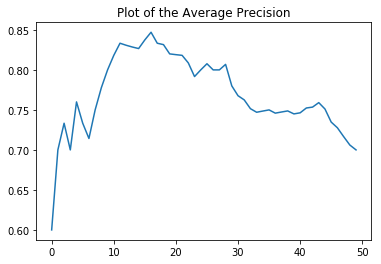

In [46]:
plt.figure()
X_MIS = [x for x in range(len(precisions_MIS))]
plt.plot(X_MIS,precisions_MIS)
plt.title('Plot of the Average Precision')
plt.show()

The high score in precision is not reached at first but around the 15th edge. Then we observe the slow decrease of the precision that characterises a good ranking.

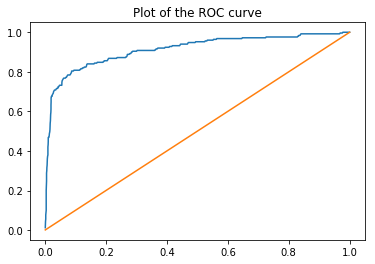

In [47]:
plt.figure()
plt.plot(fp_rates_MIS, recalls_MIS, fp_rates_MIS,fp_rates_MIS )
plt.title('Plot of the ROC curve')
plt.show()

In [48]:
AUROC(fp_rates_MIS, recalls_MIS)

0.9128912149532666

In [49]:
MAP_MIS

0.7958045097362839